### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Getting the training set

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
dataset_train.iloc[:,2:3].describe()

,High
count,1258.000000
mean,537.880223
std,153.008811
min,281.210000
25%,406.765000
50%,540.750000
75%,662.587500
max,816.680000


In [4]:
training_set = dataset_train.iloc[:, 2:3].values
training_set.shape

(1258, 1)

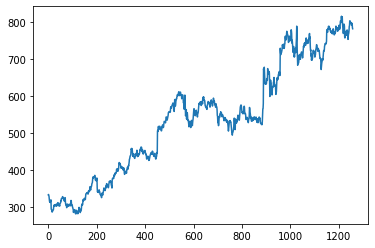

In [5]:
plt.plot(training_set)
plt.show()

### Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

training_set_scaled = scaler.fit_transform(training_set)

### Creating a data structure with 60 timesteps and 1 output


In [7]:
X_train = []
y_train = []

for i in range(len(training_set_scaled)-60):
    X_train.append(training_set_scaled[i:i+60, 0])
    y_train.append(training_set_scaled[i+60, 0])
    
X_train , y_train = np.array(X_train) , np.array(y_train)
print(X_train.shape , y_train.shape)

(1198, 60) (1198,)


In [8]:
X_train = X_train.reshape(*(X_train.shape), 1)
print(X_train.shape)

(1198, 60, 1)


###  Building the RNN/LSTM Model

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [33]:
# Initialising the Model
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences=True, input_shape = (60, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
#model.add(LSTM(units = 50, return_sequences = True))
#model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [35]:
from keras.callbacks import ModelCheckpoint , EarlyStopping
checkpoint = ModelCheckpoint('best_model.h5', monitor = 'loss', save_best_only = True)
earlystop = EarlyStopping(monitor = 'loss', patience = 5)

In [36]:
# Fitting the RNN to the Training set

hist = model.fit(X_train, y_train, epochs = 100, batch_size = 32, callbacks = [checkpoint])

Epoch 1/100
38/38 [==============================] - 5s 54ms/step - loss: 0.0737
Epoch 2/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0056
Epoch 3/100
38/38 [==============================] - 2s 65ms/step - loss: 0.0047
Epoch 4/100
38/38 [==============================] - 2s 65ms/step - loss: 0.0043
Epoch 5/100
38/38 [==============================] - 3s 66ms/step - loss: 0.0041
Epoch 6/100
38/38 [==============================] - 3s 66ms/step - loss: 0.0045
Epoch 7/100
38/38 [==============================] - 2s 64ms/step - loss: 0.0037
Epoch 8/100
38/38 [==============================] - 3s 66ms/step - loss: 0.0036
Epoch 9/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0033
Epoch 10/100
38/38 [==============================] - 2s 61ms/step - loss: 0.0031
Epoch 11/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0032
Epoch 12/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0031
Epoch 13/100
38/38 [=====

38/38 [==============================] - 2s 58ms/step - loss: 0.0013: 0s - loss: 


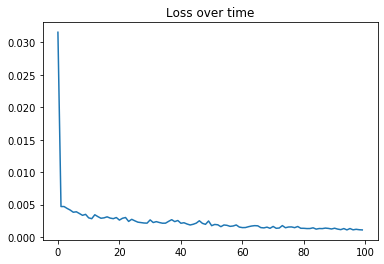

In [37]:
plt.plot(hist.history['loss'])
plt.title('Loss over time')
plt.show()

In [45]:
model.load_weights('best_model.h5')

### Making the predictions 

In [38]:
# Getting the real stock price of 2017

dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [39]:
testing_set = dataset_test.iloc[:, 2:3].values
testing_set.shape

(20, 1)

In [40]:
# Getting the predicted stock price of 2017

dataset_total = pd.concat((dataset_train['High'], dataset_test['High']), axis = 0, ignore_index = True)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

print(inputs.shape)

(80, 1)


In [41]:
X_test = []
for i in range(len(inputs)-60):
    X_test.append(inputs[i:i+60, 0])
    
X_test = np.array(X_test)
X_test = X_test.reshape(*(X_test.shape), 1)
print(X_test.shape)

(20, 60, 1)


In [42]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

### Visualising the results

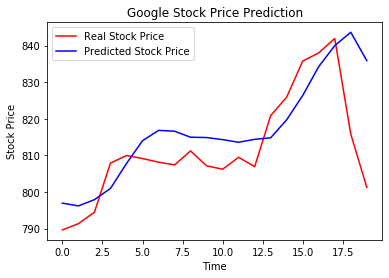

In [48]:
plt.plot(testing_set, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')

plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import r2_score

r2_score(testing_set, predicted_stock_price)

0.31507231410547876